<a href="https://colab.research.google.com/github/ACBerea/carnesa_L03-Recursive_Grid/blob/main/carnesa_L03_Grid_Approx_f25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [L03: Grid Approximation TSP](https://docs.google.com/document/d/1L8J0AKVoiDuaLXy4FjzH9eGUq8B4W-kQWj6eoGL0G40/edit?usp=sharing)

Written by Dr. Jan Pearce, Berea College

Content Edited by Dr. Mario Nakazawa, Berea College

Complete the code by meeting all linked requirements and fixing all FIXMEs

## Your Name: Andrew Carnes

**SUMMARY**: A brief summary description of the design and implementation, including how much your initial design plan evolved, the final result you achieved and the amount of time you spent as a programmer or programmers in accomplishing these results. This should be no more than two paragraphs.

This design had evolved quite a bit over time as difficulties arose. It's largest evolution happend as I struggled with combining the tours together and had to rething my methodology.

The amount of time required to complete this was around 12 hours. This was mostly due to the struggles I faced with combining the tours.

**PERSONNEL**: A description of who you worked with and on what sections.  It is expected that all collaboration is done as pair programming together. Also, note these collaborations in the code section itself.

I did not work with anyone. I did require some assistance via research.

Below are the sources I've used (Beyond the specified parameters in the doc):

GeeksforGeeks. (2020, April 2). Difference between “and” and “&” in Python. GeeksforGeeks. https://www.geeksforgeeks.org/python/difference-between-and-and-in-python/

‌Python Slicing in Depth. (n.d.). Python Tutorial - Master Python Programming for Beginners from Scratch. https://www.pythontutorial.net/advanced-python/python-slicing/


**CHALLENGES**: Descriptions of the largest challenges you overcame and what made them challenging.

The largest difficulty of this lab was completing the combineTours() function as I struggled to understand exactly how to combine the tours. I attempted to apply the WS Graph rewiring philosophy only for it to result in failure. I looked at the getBounds() function and based my methodology on it. From there I continued to get errors until I determined that overlap between the tours was causing issues in gridAppox(). I then took the appropreat steps to solve these issues.

**INNOVATIONS**:

Any innovations that were not specifically required by the assignment. These are not required, but should be highlighted if included.

**TESTING**: Describe how you tested this work.

Testing this was fairly difficult. Each test resulted in new problems and forced me to rethink what I was doing an how I was doing it. This was very difficult when it came to rewiring. I would run the code with different paremeters and mostly did testing when both functions were at pivotal points via print lines (which have been removed).

**ERRORS**: A list in bulleted form of all known errors and deficiencies.
* Some instances when the program runs with 20 random nodes result in a None return.
* By using min and max x and y boundaries, some instances of the program may cause an additional edge to appear. (Fixed via the cleanedTour method).
* Multiple syntax errors due to mispellings, indentions, and mixing up min and max x and ys. (Fixed).


**COMMENTS**: A paragraph or so of your own comments on and reactions to the Lab.

This lab was the most difficult thus far, as multiple issues and hours of diagnosing issues and correting bogged down my speed.

## Import Libraries

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from urllib.request import urlopen
import random
import itertools

### Read data

In [ ]:
def get_new_node_coords(numnodes, scale=1):
    nodeStr = f'{numnodes}\n'
    coords = []
    for i in range(numnodes):
        x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        while (x, y) in coords:
            x, y = random.randint(1, numnodes//scale), random.randint(1, numnodes//scale)
        coords.append((x, y))
        nodeStr += f'{x} {y}\n'
    return nodeStr


option1 = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-48.txt").read().decode('ASCII')
option2 = urlopen("http://cs.berea.edu/courses/csc445/data/tsp-small.txt").read().decode('ASCII')
option3 = get_new_node_coords(20)
choice = input("For option 1, type 1. For option 2, type 2. For option 3, type 3: ")

if choice == "1":
  tspdata = option1
elif choice == "2":
  tspdata = option2
else:
  tspdata = option3
print(tspdata)

For option 1, type 1. For option 2, type 2. For option 3, type 3: 2
6
1 5 
3 7 
5 11 
3 5 
5 7 
7 9 



## TSP Class

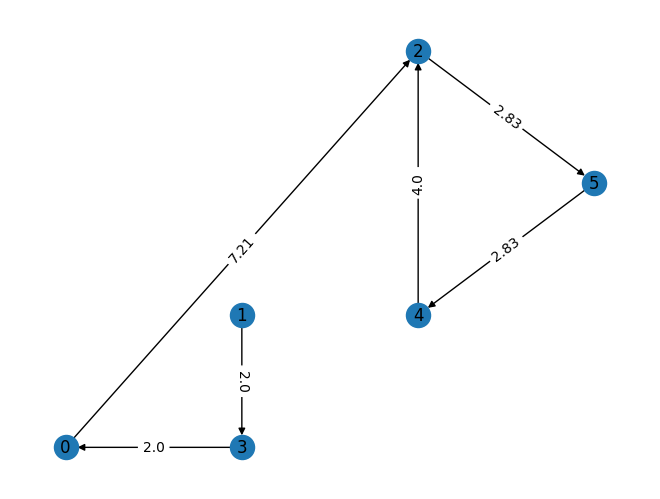

"""
6
3 7
3 5
1 5
5 11
7 9
5 7
5 11
"""


In [ ]:
"""

Given certain input, it uses the grid approximation algorithm to plot a graph and output a file of the solution path
"""

class TSP:

    def __init__(self):
        """ TSP class containing data needed for networkx graph creation, file reading and file writing.
            Creates a graph for the traveling salesperon problem
        """

        self.dimension = None
        self.nodeData = []
        self.graph = nx.DiGraph()
        self.coords = {}
        self.route = []

    def extractData(self, inputFile=""):
        """ Iterates through the input file and append each coordinate into the node list.
        Keyword Arguments:
            inputFile {str} -- a string for the file name (default: {""})
        """
        WTSPC = ['\n', '\r', '\t', ' ']
        inputData = inputFile.split()
        cleanData = [int(i) for i in inputData if i not in WTSPC]

        self.dimension = cleanData[0]

        for i in range(1, len(cleanData), 2):
            nodeX = cleanData[i]
            nodeY = cleanData[i + 1]
            self.nodeData.append([nodeX, nodeY])

    def setUpCoords(self):
        """ Puts the coordinates for each node into a dictionary as a tuple with the node as the key """
        for i in range(len(self.nodeData)):
            self.coords[i] = self.nodeData[i]

    def getDirection(self, a, b, c):
        """ Determines if the angle made by the path a-b-c is clockwise or
            couter clockwise
        Arguments:
            a {int} -- the integer index of a node
            b {int} -- the integer index of a node
            c {int} -- the integer index of a node
        Returns:
            {int} -- 1 if a->b->c is clockwise, -1 if counterclockwise
        """
        ax, ay = self.coords[a][0], self.coords[a][1]
        bx, by = self.coords[b][0], self.coords[b][1]
        cx, cy = self.coords[c][0], self.coords[c][1]
        val = (by-ay)*(cx-bx)-(bx-ax)*(cy-by)
        if val < 0:
            return -1
        elif val > 0:
            return 1
        return 0

    def calculateDistance(self, a, b):
        """ Calculates & returns the distance between points a and b
        Arguments:
            a {tuple (int)} -- tuple of numbers for the x and y coordinate of a node
            b {tuple (int)} -- tuple of numbers for the x and y coordinate of a node
        Returns:
            {float} -- the distance between the two points using the distance formula
        """
        x1 = float(a[0])
        y1 = float(a[1])
        x2 = float(b[0])
        y2 = float(b[1])
        xSquared = math.pow(x2 - x1, 2)
        ySquared = math.pow(y2 - y1, 2)
        c = round(math.sqrt(xSquared + ySquared), 2)
        return c

    def calculateTotalDistance(self, route=None):
        """
        """
        if route == None:
            route = self.route

        total = 0
        for i in range(len(route) - 1):
            n1 = self.coords[route[i]]
            n2 = self.coords[route[i+1]]
            total += self.calculateDistance(n1, n2)
        return total
# New
    def getAllTours(self, nodes):
        """ Calculates all possible tours using nodes from 'nodes'
        Arguments:
            nodes {list (int)} -- List of node numbers
        Returns:
            A list of tuples, each tuple representing a single tour
        """
        tours = list(itertools.permutations(nodes))
        return [list(t) + [t[0]] for t in tours]

# New
    def isClockwise(self, route):
        """ Decides if a route contains only clockwise angles
            NOTE: If route is of size 5, there can be a single angle that is
            the opposite of the others.
        Arguments:
            route {list (int)} -- List of node numbers on route
        Returns:
            {bool} True if all angles are clockwise, False otherwise
        """
        edges = [(route[i], route[i+1], route[i+2]) for i in range(len(route) - 2)]
        return all([self.getDirection(a, b, c) in [0, 1] for (a, b, c) in edges])
# New
    def isCounterclockwise(self, route):
        """ Decides if a route contains only counterclockwise angles
            NOTE: If route is of size 5, there can be a single angle that is
            the opposite of the others.
        Arguments:
            route {list (int)} -- List of node numbers on route
        Returns:
            {bool} True if all angles are clockwise, False otherwise
        """
        edges = [(route[i], route[i+1], route[i+2]) for i in range(len(route) - 2)]
        return all([self.getDirection(a, b, c) in [0, -1] for (a, b, c) in edges])
# New
    def horizontalPartition(self, nodes, xval):
        """ Splits the list 'nodes' into two lists, left and right, such that
            all nodes in 'left' have an x-coordinate less than or equal to
            xval, and all nodes in 'right' have an x-coordinate greater than or
            equal to xval.

            *** NOTE: THIS DOES NOT BREAK TIES.  ANY NODE WITH AN X-COORDINATE
            EQUAL TO XVAL WILL GO TO BOTH LISTS.  YOU MUST DECIDE HOW TO
            BREAK THE TIE.
        Arguments:
            nodes {list (int)} -- the list of nodes to partition
            xval {int} -- the x-coordinate boundary between partitions
        Returns:
            Two lists of ints, 'left' and 'right'.  If any nodes lie on the
            boundary, they will be included in both lists.
        """
        bounds = self.getBounds(list(range(self.graph.number_of_nodes())))
        xmin, xmax = bounds['xmin'], bounds['xmax']
        ymin, ymax = bounds['ymin'], bounds['ymax']

        left = self.getNodesBetween(nodes, xmin, xval, ymin, ymax)
        right = self.getNodesBetween(nodes, xval, xmax, ymin, ymax)
        return left, right
# New
    def verticalPartition(self, nodes, yval):
        """ Splits the list 'nodes' into two lists, top and bottom, such that
            all nodes in 'top' have a y-coordinate greater than or equal to
            yval, and all nodes in 'bottom' have a y-coordinate less than or
            equal to yval.

            *** NOTE: THIS DOES NOT BREAK TIES.  ANY NODE WITH A Y-COORDINATE
            EQUAL TO YVAL WILL GO TO BOTH LISTS.  YOU MUST DECIDE HOW TO
            BREAK THE TIE.
        Arguments:
            nodes {list (int)} -- the list of nodes to partition
            yval {int} -- the y-coordinate boundary between partitions
        Returns:
            Two lists of ints, 'top' and 'bottom'.  If any nodes lie on the
            boundary, they will be included in both lists.
        """
        bounds = self.getBounds(list(range(self.graph.number_of_nodes())))
        xmin, xmax = bounds['xmin'], bounds['xmax']
        ymin, ymax = bounds['ymin'], bounds['ymax']

        top = self.getNodesBetween(nodes, xmin, xmax, yval, ymax)
        bottom = self.getNodesBetween(nodes, xmin, xmax, ymin, yval)
        return top, bottom
# New
    def getBounds(self, nodes):
        """ Gets the bounding box containing every node in 'nodes'
        Arguments:
            nodes {list (int)} -- List of node numbers to bound
        Returns:
            dict {(str) : (int)} mapping the strings 'xmax', 'xmin', 'ymax', 'ymin'
            to the corresponding bounding values
        """
        allcoords = [self.coords[i] for i in nodes]
        myx = [i[0] for i in allcoords]
        myy = [i[1] for i in allcoords]
        return {'xmax': max(myx), 'xmin': min(myx),
                'ymax': max(myy), 'ymin': min(myy)}

        # To use this elsewhere in the code, do something like:
        # bounds = self.getBounds([0, 1, 2, 3, 4])
        # my_minimum_x_value = bounds['xmin']
        # my_maximum_y_value = bounds['ymax']
# New
    def getNodesBetween(self, nodes, xmin, xmax, ymin, ymax):
        """ Returns all nodes within the specified bounding box
        Argments:
            nodes {list (int)} -- the list of nodes to search within
            xmin {int} -- The minimum x-value for any node
            xmax {int} -- The maximum x-value for any node
            ymin {int} -- The minimum y-value for any node
            ymax {int} -- The maximum y-value for any node
        Returns:
            {list (int)} -- A list of node numbers that fall within the
            specified bounding box
        """
        ret = []
        for i in nodes:
            myx = self.coords[i][0]
            myy = self.coords[i][1]
            if (xmin <= myx <= xmax) and (ymin <= myy <= ymax):
                ret.append(i)
        return ret

    def gridApprox(self, currentNodes=None):
        """ Uses the grid approximation algorithm. Gets the route order and
            adds the starting place to the end of the route.
        Keyword Arguments:
            currentNodes {list (int)} -- the list of node indexes within the
            current segment of the grid.  If no value is provided, currentNodes
            is assigned the set of all nodes in the graph.
        """
        if currentNodes is None:
            currentNodes = list(range(self.graph.number_of_nodes()))

        # Determine if you are in the base case (Added lower bound for edge casing)
        if len(currentNodes) <= 5 and len(currentNodes) > 0:
        # If so, determine a tour by brute force.
          bestTour = None
          bestTourLen = float('inf')
          # Get the distance of all tours and determine which tour is the best.
          for tour in self.getAllTours(currentNodes):
            dist = self.calculateTotalDistance(tour)
            if dist < bestTourLen:
              bestTourLen = dist
              bestTour = tour[:]
        # Clockwise correction.
          if not self.isClockwise(bestTour):
            bestTour = list(reversed(bestTour))

        # Return brute force solution.
          return bestTour

        # Otherwise, determine how to split currentNodes.
        elif len(currentNodes) > 5:
          # Core Components of Graph:
          # getBounds (min/max x and ys)
          # Determine inital starting split
          # Set the bound to the current boundaries of the graph.
          bound = self.getBounds(currentNodes)
          # Get the mins and maxes of each axis
          grid_x_min = bound['xmin']
          grid_x_max = bound['xmax']
          grid_y_min = bound['ymin']
          grid_y_max = bound['ymax']
          # Set the width and height.
          width = grid_x_max - grid_x_min

          height = grid_y_max - grid_y_min

          # Split vertical (across x)
          if width >= height:
            # Determine the split value.
            splitX = (grid_x_min + grid_x_max) / 2

            # Recurse with horizontalPartion().
            leftNodes, rightNodes = self.horizontalPartition(currentNodes, splitX)

            # If a node lies on two boundaries, split based on which side holds the minority of the nodes.
            # Tie breaker.
            graphSets = set(leftNodes) & set(rightNodes)
            for node in graphSets:
              if len(leftNodes) > len(rightNodes):
                leftNodes.remove(node)
              else:
                rightNodes.remove(node)

           # Recursion:
            leftTour = self.gridApprox(leftNodes)
            rightTour = self.gridApprox(rightNodes)

           # Combine:
            return self.combineTours(leftTour, rightTour, split='horizontal')

        # Split horizontal (across y)
          else:
            # Determine the split value.
            splitY = (grid_y_min + grid_y_max) / 2

            # Recurse with verticalPartion().
            topNodes, bottomNodes = self.verticalPartition(currentNodes, splitY)

            # If a node lies on two boundaries, split based on which side holds the minority of the nodes.
            # Tie breaker.
            overlapingNodes = set(topNodes) & set(bottomNodes)
            for node in overlapingNodes:
              if len(topNodes) > len(bottomNodes):
                topNodes.remove(node)
              else:
                bottomNodes.remove(node)
            # Recursion:
            topTour = self.gridApprox(topNodes)
            bottomTour = self.gridApprox(bottomNodes)

          # Combine:
          # Then, call this method again on each of the new, smaller node sets.
          # Once all your recursive calls return, you need a way to combine two
          # tours.
        # Final return.
          return self.combineTours(topTour, bottomTour, split='vertical')
        else:
          return []

    # Account for split when combining tours (Default split seems to be horizontal)
    def combineTours(self, tour1, tour2, split='horizontal'):
        """ Combines two tours by finding a place to rewire two edges.
        Arguments:
            tour1 {list (int)} -- Either the Left or Top tour based on the splits orientation.
            tour2 {list (int)} -- Either the Right or Bottem tour based on the splits orientation.
            split {str} -- Either 'horizontal' or 'vertical'.  Helps you keep
            track of how you split the two chunks you are now combining.
        Returns:
            A list of ints representing the new combined tour.
        """
        # Used to handle empty tours that could result in errors. Check if any of the tours are empty and return a copy of the opposite tour.
        if not tour1:
          return tour2[:]
        if not tour2:
          return tour1[:]

        # Initalize the boundaries for both tours.
        boundT1 = self.getBounds(tour1)
        boundT2 = self.getBounds(tour2)

        # Return the tours if either of the tours are empty (nothing to combine)
        if split not in ('horizontal', 'vertical'):
          return tour1 + tour2

        if split=='horizontal':
          # min value for right (as it desires the left).
          # max value for left (max value for the left as it desires the right).
          # Right is tour1
          # Left is tour2
          # Find and combine the boundaries (furthest values from the partition lines).
          # Uses x coord
        # Find the rightmost by comparing the x coordinate to the inital xmin boundary.
          boundaryRight = None
          boundaryRightX= boundT1['xmin']
          for n in tour1:
            x = self.coords[n][0]
            if x > boundaryRightX:
              boundaryRight = n
              boundaryRightX = x
        # Find the leftmost node by comparing to the x coordinate to the inital xmax boundary.
          boundaryLeft = None
          boundaryLeftX = boundT2['xmax']
          for n in tour2:
            x = self.coords[n][0]
            if x < boundaryLeftX:
              boundaryLeft = n
              boundaryLeftX = x

          # Find the index of each tour
          indexRight = tour1.index(boundaryRight)
          indexLeft = tour2.index(boundaryLeft)

          # Reorder the tours with the boundary nodes at the start (since their the nodes that will be rewired.) (Slicing is used for wrapping as well to keep the node order.)
          tour1Reorder = tour1[indexRight:] + tour1[:indexRight]
          tour2Reorder = tour2[indexLeft:] + tour2[:indexLeft]

          # Compares the distance of the reordered tour 1 from the other tour's start point while also comparing the distance from both tours from each endpoint. If the first instance is greater than the second, then tour2Reorder needs to be inverted to fit the order.
          if self.calculateDistance(self.coords[tour1Reorder[-1]], self.coords[tour2Reorder[0]]) > self.calculateDistance(self.coords[tour1Reorder[-1]], self.coords[tour2Reorder[-1]]):
            tour2Reorder = list(reversed(tour2Reorder))

          # Combine
          combinedTour = tour1Reorder + tour2Reorder

        elif split=='vertical':
          # Top is tour1
          # Bottem is tour2
          # Find the topmost node by comparing the y coordinate to the inital negative y boundary.
          boundaryTop = None
          boundaryTopY = float('-inf')
          for n in tour1:
            y = self.coords[n][1]
            if y > boundaryTopY:
              boundaryTop = n
              boundaryTopY = y
        # Find the botteommost node by comparing the y coordinate to the inital y boundary.
          boundaryBottom = None
          boundaryBottomY = float('inf')
          for n in tour2:
            y = self.coords[n][1]
            if y < boundaryBottomY:
              boundaryBottom = n
              boundaryBottomY = y

          # Find the index of each tour
          indexTop = tour1.index(boundaryTop)
          indexBottom = tour2.index(boundaryBottom)

          # Reorder the tours with the boundary nodes at the start (since their the nodes that will be rewired.) (Slicing is used for wrapping as well to keep the node order.)
          tour1Reorder = tour1[indexTop:] + tour1[:indexTop]
          tour2Reorder = tour2[indexBottom:] + tour2[:indexBottom]

         # Compares the distance of the reordered tour 1 from the other tour's start point while also comparing the distance from both tours from each endpoint. If the first instance is greater than the second, then tour2Reorder needs to be inverted to fit the order.
          if self.calculateDistance(self.coords[tour1Reorder[-1]], self.coords[tour2Reorder[0]]) > self.calculateDistance(self.coords[tour1Reorder[-1]], self.coords[tour2Reorder[-1]]):
            tour2Reorder = list(reversed(tour2Reorder))

          # Combine
          combinedTour = tour1Reorder + tour2Reorder
          # Remove Tour Duplication
        cleanedTour = [combinedTour[0]]
        for n in combinedTour[1:]:
          if n != cleanedTour[-1]:
            cleanedTour.append(n)
        return cleanedTour

    def addNodes(self):
        """ Adds nodes to the networkx graph
        """
        for node in self.coords:
            self.graph.add_node(node, pos=self.coords[node])

    def addEdges(self, route=None):
        """Adds edges to a networkx graph
        """
        if route == None:
            route = self.route
        x = 0
        while x < len(route) - 1:
            self.graph.add_edge(route[x], route[x+1],
                                weight=self.calculateDistance(self.coords[route[x]], self.coords[route[x+1]]))
            x += 1

    def showGraph(self):
        """Uses the imported libraries to display the graph
        """
        # get labels and coordinates for the graph
        coords = nx.get_node_attributes(self.graph, 'pos')
        labels = nx.get_edge_attributes(self.graph, 'weight')
        # draw nodes in their coordinates
        nx.draw(self.graph, coords)
        nx.draw_networkx_labels(self.graph, coords)
        # draw edges with their weights
        nx.draw_networkx_edge_labels(self.graph, coords, edge_labels=labels)
        plt.show()

    def tourResultsDocstring(self):
      """Creates a docstring based on the tour route of the graph and assists in displaying the results.
      Returns:
          [str] -- a string of the docstring with the route of the graph.
      """
      # Creates the docstring formating.
      docstring = '"""'
      # Uses self.dimension to ensure that only unique visits are counted in the node total, but not excluded from the results.
      route_lines = [str((self.dimension))]
    # Gets the x and y positions of each corrdinate for each node and adds it to the route_lines string.
      for node in self.route:
        x, y = self.coords[node]
       # Formates and appends the x and y values of each coordinate to mimic the appearance of the txt files.
        route_lines.append(f"{x} {y}")

      return docstring + "\n" + "\n".join(route_lines) + "\n" + docstring


def main():
    # Create TSP object
    tsp = TSP()

    # Perform initial setup with data generated above
    tsp.extractData(tspdata)
    tsp.setUpCoords()
    tsp.addNodes()

    # Call the grid approximation method
    tsp.route = tsp.gridApprox()
    tsp.addEdges(tsp.route)
    tsp.showGraph()
    # Print Tour Results
    print(tsp.tourResultsDocstring())

main()

## Integrity statement
Please briefly describe all references used, all help you received and all help you gave to others in completing this assignment. Be sure to say that you got no help if you got none.